<h1> Analysis and Visualization of Urban Accessibility and Economic Landscapes  </h1>
<b>Team Name:</b> Big Data Explorers <br>
<b>Team Members:</b> <br>
<ul>
    <li> Anirudh Nittur Venkatesh 862465839 nitt003 </li>
    <li> Lakhan Kumar Sunilkumar 862481700 lsuni001 </li>
    <li> Khayati Shah 862481455 kshah110 </li>
    <li> Hrishitha Pulipaka 862548174 phris002 </li>
    <li> Rohan Tikotekar 862548066 rtiko001 </li>

</ul>

# Import Libraries and Run PySpark

In [ ]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import *
from pyspark.sql.functions import lit, col
from functools import reduce

import matplotlib.pyplot as plt
import time, csv, os, math, re, glob

ModuleNotFoundError: No module named 'matplotlib'

In [5]:
spark = SparkSession.builder.appName(name='California-UCRStar').getOrCreate()

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.UnsupportedOperationException: getSubject is supported only if a security manager is allowed
	at java.base/javax.security.auth.Subject.getSubject(Subject.java:347)
	at org.apache.hadoop.security.UserGroupInformation.getCurrentUser(UserGroupInformation.java:577)
	at org.apache.spark.util.Utils$.$anonfun$getCurrentUserName$1(Utils.scala:2416)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.util.Utils$.getCurrentUserName(Utils.scala:2416)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:329)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:62)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:501)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:485)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1575)


In [11]:
spark

# Data Cleaning and Loading

<h4> Data Cleaning performed by <b>Rohan</b> and <b>Hrishitha</b></h4`>
<h4> Data Loading and Schema created by <b>Lakhan</b></h4> 

## Loading Road Dataset to Dataframe

In [12]:
# Reformatting of Road Dataset into Geometry coordinates for California Dataset only

# Input and output file paths
input_file = "../Datasets/Input-Datasets/OSM2015_roads_California_USA.csv"  # Input file 
output_file = "../Datasets/Input-Datasets/cleaned/OSM2015_roads_California_USA_cleaned.csv"  # Output file

# Function to reformat each row
with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", newline="", encoding="utf-8") as outfile:
    reader = csv.DictReader(infile, delimiter="\t")  # Read with tab delimiter
    fieldnames = ["id", "geometry", "name", "metadata"]      # Define new fieldnames
    writer = csv.DictWriter(
        outfile,
        fieldnames=fieldnames,
        quoting=csv.QUOTE_NONNUMERIC,  # Quote only non-numeric fields
        quotechar='"'                  # Use double quotes
    )
    
    # Write the header row
    writer.writeheader()
    
    # Process each row in the input file
    for row in reader:
        writer.writerow({
            "id": "road",
            "geometry": row["geometry"],
            "name": row["$2"],
            "metadata": ""
        })

In [13]:
road_Stime = time.time()

df_road = spark.read.csv('../Datasets/Input-Datasets/cleaned/OSM2015_roads_California_USA_cleaned.csv', header=True)

road_Ltime = time.time() - road_Stime

df_road = df_road.select(
    lit("roads").alias("id"),
    col("geometry"),
    col("name"),
    lit("").alias("metadata")
)

road_Rtime = time.time() - road_Stime

print("Total Number of road records: ",df_road.count())

Total Number of road records:  1071298


## Manually define the Schema

In [14]:
# Manually define schema

# road_schema = StructType([
#     StructField("geometry", StringType(), True),
#     StructField("$1", IntegerType(), True),
#     StructField("$2", StringType(), True)
# ])

# df_road = spark.read.schema(schema=road_schema).csv('../OSM2015_roads.csv').dropna()

# #Drop Missing or Corrupted Records

# df_road = df_road.withColumn("$3", lit(None).cast("string"))

# print(f"List of Columns {df_road.columns}\n" )

# print(f"Total number of records: {df_road.count()}")

## Loading Buildings Dataset to Dataframe

In [15]:
building_Stime = time.time()

df_building = spark.read.csv("../Datasets/Input-Datasets/cleaned/MSBuildings_California_USA.csv", header=True)

buidling_Ltime = time.time() - building_Stime


df_building = df_building.select(
    lit("buildings").alias("id"),
    col("geometry"),
    lit("").alias("name"),
    lit("").alias("metadata")
)

buidling_Rtime = time.time() - building_Stime

print("Total Number of buildings records: ",df_building.count())

Total Number of buildings records:  10984928


## Loading Stanford-Gowalla (Point of Interest) Dataset to Dataframe

In [16]:
# Reformat Stanford Gowalla csv file 

input_file = "../Datasets/Input-Datasets/stanford-gowalla_California_USA.csv"
output_file = "../Datasets/Input-Datasets/cleaned/stanford-gowalla_California_USA_cleaned.csv"

with open(input_file, "r") as infile, open(output_file, "w", newline="") as outfile:
    reader = csv.DictReader(infile, delimiter="\t")  
    fieldnames = ["id", "geometry", "name", "metadata"]    
    writer = csv.DictWriter(
        outfile,
        fieldnames=fieldnames,
        quoting=csv.QUOTE_NONNUMERIC,  
        quotechar='"'
    )
    
    writer.writeheader()
    
    for row in reader:
        writer.writerow({
            "id": "gowalla",
            "geometry": f"POINT ({row["x"]} {row["y"]})",
            "name": "",
            "metadata": row["$2"]
        })

In [17]:
gowalla_Stime = time.time()

df_gow = spark.read.csv('../Datasets/Input-Datasets/cleaned/stanford-gowalla_California_USA_cleaned.csv', header=True)

gowalla_Ltime = time.time() - gowalla_Stime

df_gow = df_gow.select(
    col("id"),
    col("geometry"),
    lit("").alias("name"),
    col("metadata"),
)

gowalla_Rtime = time.time() - gowalla_Stime

print("Total Number of buildings records: ",df_gow.count())

Total Number of buildings records:  666452


## Geospatial env and socio archive.zip Data Cleaning

In [18]:
def matches_pattern(name, patterns):
    for pattern in patterns:
        if re.search(pattern, name, re.IGNORECASE):  # Case-insensitive search
            return True
    return False

def geospa_zip_clean(csv_input, csv_output, csv_filter, given_name):
    

    # List of names to filter
    filter_list = csv_filter

    with open(csv_input, "r", encoding="utf-8") as infile, open(csv_output, "w", newline="") as outfile:
        reader = csv.DictReader(infile)
        fieldnames = ["geometry", "name", "metadata"] 
        writer = csv.DictWriter(outfile, 
                                fieldnames=fieldnames,
                                quoting=csv.QUOTE_ALL,
                                quotechar='"')
    
        writer.writeheader()
    
        for row in reader:
            if matches_pattern(row["name"], filter_list):
                writer.writerow({
                    "geometry": row["WKT"],
                    "name": row[given_name],
                    "metadata": ""
                    }
                )

## Loading Airport Dataset to Dataframe

In [19]:
# Clean airport dataset

airport_filter_list = [
    "Arcata", "Eureka", "Bakersfield", "Burbank", "Fresno", "Long Beach", "Los Angeles",
    "Monterey", "Oakland", "Ontario", "Palm Springs", "Redding", "Sacramento",
    "San Diego", "San Francisco", "San Jose", "San Luis Obispo", "Santa Ana",
    "Santa Barbara", "Santa Maria", "Santa Rosa", "Stockton"
]

geospa_zip_clean(csv_input='../Datasets/Input-Datasets/ne_10m_airports.csv', csv_output='../Datasets/Input-Datasets/cleaned/airports.csv', csv_filter=airport_filter_list, given_name="name_en")


In [20]:
airport_Stime = time.time()

df_airport = spark.read.csv("../Datasets/Input-Datasets/cleaned/airports.csv", header=True)

airport_Ltime = time.time() - airport_Stime

df_airport = df_airport.select(
    lit("airport").alias("id"),
    col("geometry"),
    col("name"),
    lit("").alias("metadata")
)

airport_Rtime = time.time() - airport_Stime

print("Total Number of buildings records: ",df_airport.count())

Total Number of buildings records:  10


## Loading Port Dataset to Dataframe

In [21]:
port_filter_list = ["Eureka", "Long Beach", "Los Angeles", "Oakland", "Port Hueneme", "Redwood City", 
                    "Richmond", "San Diego", "San Francisco", "Stockton", "West Sacramento"]

geospa_zip_clean(csv_input='../Datasets/Input-Datasets/ne_10m_ports.csv', csv_output='../Datasets/Input-Datasets/cleaned/ports.csv', csv_filter=port_filter_list, given_name="name")

In [22]:
port_Stime = time.time()

df_port = spark.read.csv("../Datasets/Input-Datasets/cleaned/ports.csv", header=True)

port_Ltime = time.time() - port_Stime

df_port = df_port.select(
    lit("port").alias("id"),
    col("geometry"),
    col("name"),
    lit("").alias("metadata")
)

port_Rtime = time.time() - port_Stime

print("Total Number of buildings records: ",df_port.count())

Total Number of buildings records:  9


## Loading Population Dataset to Dataframe

In [23]:

# Reformat NEPopulated_places csv file 

input_file = "../Datasets/Input-Datasets/NE_populated_places_California_USA.csv"
output_file = "../Datasets/Input-Datasets/cleaned/NE_populated_places_California_USA_cleaned.csv"

with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", newline="") as outfile:
    reader = csv.DictReader(infile) 
    fieldnames = ["id", "geometry", "name", "metadata"]
    writer = csv.DictWriter(
        outfile,
        fieldnames=fieldnames,
        quoting=csv.QUOTE_NONNUMERIC,
        quotechar='"'
    )
    
    writer.writeheader()
    
    for row in reader:
        writer.writerow({
            "id": "population",
            "geometry": f"POINT ({row['x']} {row['y']})",
            "name": row["NAME"],
            "metadata": row["POP_MAX"]
        })

In [24]:
population_Stime = time.time()

df_population = spark.read.csv('../Datasets/Input-Datasets/cleaned/NE_populated_places_California_USA_cleaned.csv', header=True)

population_Ltime = time.time() - population_Stime

df_population = df_population.select(
    lit("port").alias("id"),
    col("geometry"),
    col("name"),
    col("metadata")
)

population_Rtime = time.time() - population_Stime

print("Total Number of population records: ",df_gow.count())

Total Number of population records:  666452


# Combining Dataframes

<h4> Created by <b>Lakhan</b></h4> 

## Test Union Method of Combining DataFrames

In [25]:
# Combine using union method

# combined_df = df_road.union(df_building)
# combined_df.head(20)

## Python's Reduce method and DataFrame.union from Pyspark 

In [26]:
# Perform union operation using reduce

dfs_list = [df_road, df_building, df_gow, df_airport, df_port, df_population]
df_combined = reduce(DataFrame.union, dfs_list)


In [27]:
print(f"\n Rows Count: {df_combined.count()}, Partitions {df_combined.rdd.getNumPartitions()}")


 Rows Count: 12722745, Partitions 32


In [28]:
df_combined.printSchema()

root
 |-- id: string (nullable = true)
 |-- geometry: string (nullable = true)
 |-- name: string (nullable = true)
 |-- metadata: string (nullable = true)



# Saving Dataframes into CSV and JSON

<h4> Performed by <b>Lakhan</b> and <b>Hrishitha</b></h4>

## Save to CSV File

In [29]:
# Distributed Files
try:
    csvD_save_start = time.time()
    
    # Save it in distributed system
    df_combined.write.csv('../Datasets/Output-Datasets/Output-CSV', header=True, mode="overwrite")
except:
    print("Error in Saving the CSV File")
else:
    print("CSV Distributed file saved successfully \n")
    csvD_save_end = time.time() - csvD_save_start
    print(f"CSV Distributed file saved: {df_combined.rdd.getNumPartitions()}",end="\n")
finally:
    pass


# Single File
try:
    csvS_save_start = time.time()

    # Save it in a single file
    df_combined.coalesce(1).write.csv('../Datasets/Output-Datasets/Output-CSV-Single', header=True, mode="overwrite")    
except:
    print("Error in Saving the CSV File")
else:
    print("CSV Single file saved successfully \n")
    csvS_save_end = time.time() - csvS_save_start
finally:
    pass

CSV Distributed file saved successfully 

CSV Distributed file saved: 32
CSV Single file saved successfully 



## Save to JSON file

In [30]:
# Distributed File 
try:
    jsonD_save_start = time.time() 
    
    df_combined.write.json('../Datasets/Output-Datasets/Output-JSON', mode="overwrite")
except:
    print("Error in Saving the JSON file")
else:
    print("JSON file saved successfully \n")
    
    jsonD_save_end = time.time() - jsonD_save_start
    print(f"JSON Distributed file saved: {df_combined.rdd.getNumPartitions()}", end="\n")
finally:
    pass

# Single File
try:
    jsonS_save_start = time.time() 
    
    df_combined.coalesce(1).write.json('../Datasets/Output-Datasets/Output-JSON-Single', mode="overwrite")
except:
    print("Error in Saving the JSON file")
else:
    print("JSON file saved successfully \n")
    jsonS_save_end = time.time() - jsonS_save_start
finally:
    pass

JSON file saved successfully 

JSON Distributed file saved: 32
JSON file saved successfully 



In [31]:
file_pattern = "../Datasets/Output-Datasets/Output-JSON-Single/"+"part-00*.json"
file_name = glob.glob(file_pattern)[0]
raw_data = spark.read.json(file_name)
raw_data.head(10)

[Row(geometry='LINESTRING (-118.435178 37.901289, -118.4022316 37.9262586, -118.3713754 37.9517107, -118.3677276 37.9546886, -118.3666118 37.955433, -118.3656248 37.9559744, -118.3580658 37.958995, -118.3545992 37.9603802, -118.354143 37.960541, -118.353694 37.960648, -118.353336 37.960717, -118.352993 37.960766, -118.352322 37.960803, -118.352106 37.960801, -118.351917 37.960793, -118.351844 37.960785, -118.351728 37.960773, -118.351447 37.96074, -118.35093 37.960644, -118.350561 37.960557, -118.34994 37.96039, -118.349358 37.960251, -118.3488678 37.960128)', id='roads', metadata='', name='[tiger:county#Mineral_ NV,ref#US 6,highway#primary,hgv:national_network#yes,name#Grand Army of the Republic Highway,NHS#STRAHNET,hgv#designated,lanes#2,source:hgv:national_network#Title 23: Highways Part 658 http://ecfr.gpoaccess.gov/cgi/t/text/text-idx?c=ecfr&rgn=div5&view=text&node=23:1.0.1.7.33&idno=23 and document from NDOT listing the FAP routes]'),
 Row(geometry='LINESTRING (-118.618573 37.961

# Metrics and Evaluation

<h4> Performed by <b>Lakhan</b> and <b>Khayati</b></h4>

## Plot time taken to load each dataset

Road Dataset Load Time: 4.17 Secs
Building Dataset Load Time: 0.34 Secs
Stanford Gowalla Dataset Load Time: 0.18 Secs
Airport Dataset Load Time: 0.17 Secs
Port Dataset Load Time: 0.19 Secs
Population Dataset Load Time: 0.23 Secs


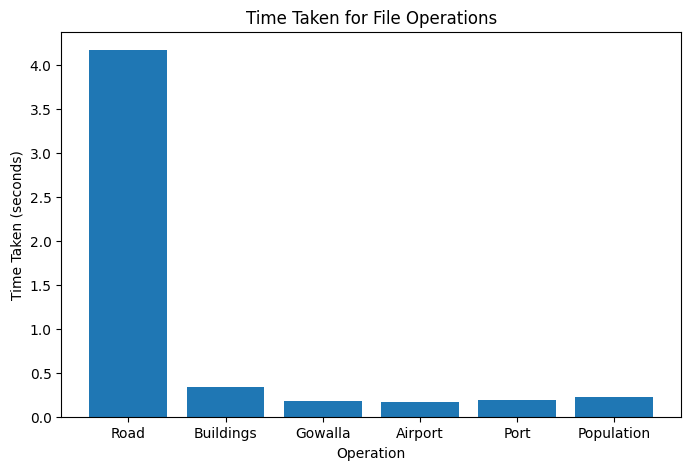

In [32]:
operation_read = ['Road', 'Buildings', 'Gowalla', 'Airport', 'Port', 'Population']
read_times = [road_Rtime, buidling_Rtime, gowalla_Rtime, airport_Rtime, port_Rtime, population_Rtime]

print(f"Road Dataset Load Time: {road_Rtime:.2f} Secs",end="\n")
print(f"Building Dataset Load Time: {buidling_Rtime:.2f} Secs",end="\n")
print(f"Stanford Gowalla Dataset Load Time: {gowalla_Rtime:.2f} Secs",end="\n")
print(f"Airport Dataset Load Time: {airport_Rtime:.2f} Secs",end="\n")
print(f"Port Dataset Load Time: {port_Rtime:.2f} Secs",end="\n")
print(f"Population Dataset Load Time: {population_Rtime:.2f} Secs",end="\n")

plt.figure(figsize=(8, 5))
plt.bar(operation_read, read_times)
plt.xlabel('Operation')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken for File Operations')
plt.show()

## Plot time taken to save data

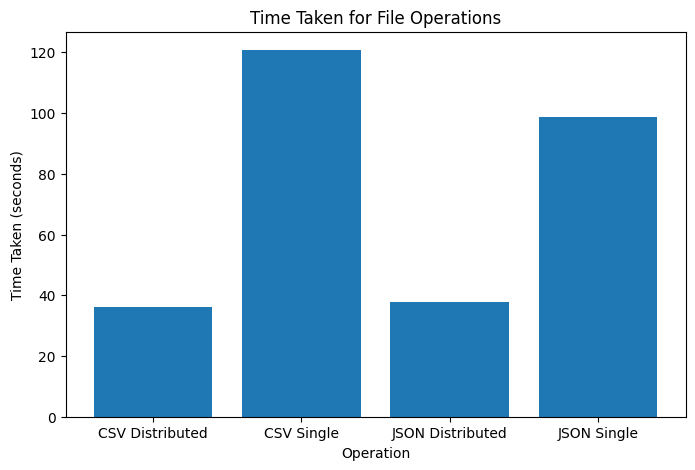

In [33]:
save_operation = ['CSV Distributed', 'CSV Single', 'JSON Distributed', 'JSON Single']
save_times = [csvD_save_end, csvS_save_end, jsonD_save_end, jsonS_save_end]

plt.figure(figsize=(8, 5))
plt.bar(save_operation, save_times)
plt.xlabel('Operation')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken for File Operations')
plt.show()

## Data Volume Metrics

### Reduction Ratio

In [34]:
# Function to get folder size 
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size

# Function to Convert bytes to a human-readable format
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"

# Calculate the reduction ratio.
def calculate_reduction_ratio(input_size, output_size):
    return ((input_size - output_size) / input_size) * 100

# Specify folder paths
input_folder = "../Datasets/Input-Datasets/cleaned"
output_folders = {
    "Output-CSV": "../Datasets/Output-Datasets/Output-CSV",
    "Output-CSV-Single": "../Datasets/Output-Datasets/Output-CSV-Single",
    "Output-JSON": "../Datasets/Output-Datasets/Output-JSON",
    "Output-JSON-Single": "../Datasets/Output-Datasets/Output-JSON-Single"
}

# Get folder sizes
input_size = get_folder_size(input_folder)
output_sizes = {key: get_folder_size(value) for key, value in output_folders.items()}

# Display folder sizes
print(f"Input folder size: {convert_size(input_size)}")
for key, size in output_sizes.items():
    print(f"{key} folder size: {convert_size(size)}")

# Calculate and display reduction ratios
print("\nReduction Ratios:")
for key, size in output_sizes.items():
    reduction_ratio = calculate_reduction_ratio(input_size, size)
    print(f"{key} Reduction Ratio: {reduction_ratio:.2f}%")


Input folder size: 2.24 GB
Output-CSV folder size: 1.13 GB
Output-CSV-Single folder size: 1.13 GB
Output-JSON folder size: 1.6 GB
Output-JSON-Single folder size: 1.6 GB

Reduction Ratios:
Output-CSV Reduction Ratio: 49.54%
Output-CSV-Single Reduction Ratio: 49.54%
Output-JSON Reduction Ratio: 28.78%
Output-JSON-Single Reduction Ratio: 28.78%


### Visualization

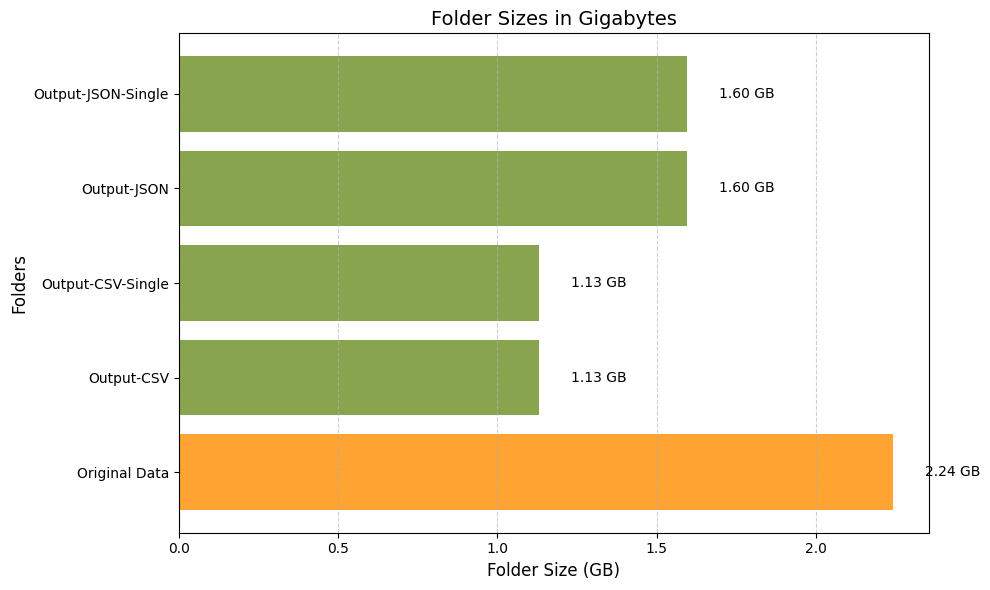

In [35]:
def convert_to_gb(size_bytes):
    return size_bytes / (1024 ** 3)

# Specify folder paths
input_folder = "../Datasets/Input-Datasets/cleaned"
output_folders = {
    "Output-CSV": "../Datasets/Output-Datasets/Output-CSV",
    "Output-CSV-Single": "../Datasets/Output-Datasets/Output-CSV-Single",
    "Output-JSON": "../Datasets/Output-Datasets/Output-JSON",
    "Output-JSON-Single": "../Datasets/Output-Datasets/Output-JSON-Single"
}


# Get folder sizes
input_size = get_folder_size(input_folder)
output_sizes = {key: get_folder_size(value) for key, value in output_folders.items()}

# Convert sizes to gigabytes
input_size_gb = convert_to_gb(input_size)
output_sizes_gb = {key: convert_to_gb(size) for key, size in output_sizes.items()}

# Prepare data for plotting
folders = ["Original Data"] + list(output_sizes_gb.keys())
sizes_gb = [input_size_gb] + list(output_sizes_gb.values())
colors = ["darkorange"] + ["olivedrab"] * len(output_sizes_gb)

# Plot horizontal bar graph
plt.figure(figsize=(10, 6))
plt.barh(folders, sizes_gb, color=colors, alpha=0.8)
plt.xlabel("Folder Size (GB)", fontsize=12)
plt.ylabel("Folders", fontsize=12)
plt.title("Folder Sizes in Gigabytes", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Annotate bars with sizes
for index, size in enumerate(sizes_gb):
    plt.text(size + 0.1, index, f"{size:.2f} GB", va="center", fontsize=10)

plt.tight_layout()
plt.show()

## Read and Write Throughput

In [36]:
def convert_to_mb(bytes_size):
    return bytes_size / (1024 * 1024)

# Function to Calculate the Throughput
def calculate_throughput(file_size_mb, time_taken_s):
    return file_size_mb / time_taken_s if time_taken_s > 0 else 0
 
file_size_bytes = get_folder_size("../Datasets/Input-Datasets/cleaned")
file_size_mb = convert_to_mb(file_size_bytes)

total_read_time = road_Rtime + buidling_Rtime + gowalla_Rtime + airport_Rtime + port_Rtime + population_Rtime

# Calculate Read Throughput 
read_throughput = calculate_throughput(file_size_mb, total_read_time)
print(f"Original Dataset Read Throughput: {read_throughput:.2f} MB/s", end="\n\n") 

#Calculate Write Throughput 
write_throughput_csvD = calculate_throughput(convert_to_mb(get_folder_size("../Datasets/Output-Datasets/Output-CSV")), csvD_save_end)
print(f"CSV Distributed Write Throughtput: {write_throughput_csvD:.2f} MB/s", end="\n")

write_throughput_csvS = calculate_throughput(convert_to_mb(get_folder_size("../Datasets/Output-Datasets/Output-CSV-Single")), csvS_save_end)
print(f"CSV Single Write Throughtput: {write_throughput_csvS:.2f} MB/s", end="\n")

write_throughput_jsonD = calculate_throughput(convert_to_mb(get_folder_size("../Datasets/Output-Datasets/Output-JSON")), jsonD_save_end)
print(f"JSON Distributed Write Throughtput: {write_throughput_jsonD:.2f} MB/s", end="\n")

write_throughput_jsonS = calculate_throughput(convert_to_mb(get_folder_size("../Datasets/Output-Datasets/Output-JSON-Single")), jsonS_save_end)
print(f"JSON Single Write Throughtput: {write_throughput_jsonS:.2f} MB/s")

Original Dataset Read Throughput: 435.24 MB/s

CSV Distributed Write Throughtput: 32.07 MB/s
CSV Single Write Throughtput: 9.59 MB/s
JSON Distributed Write Throughtput: 43.11 MB/s
JSON Single Write Throughtput: 16.54 MB/s


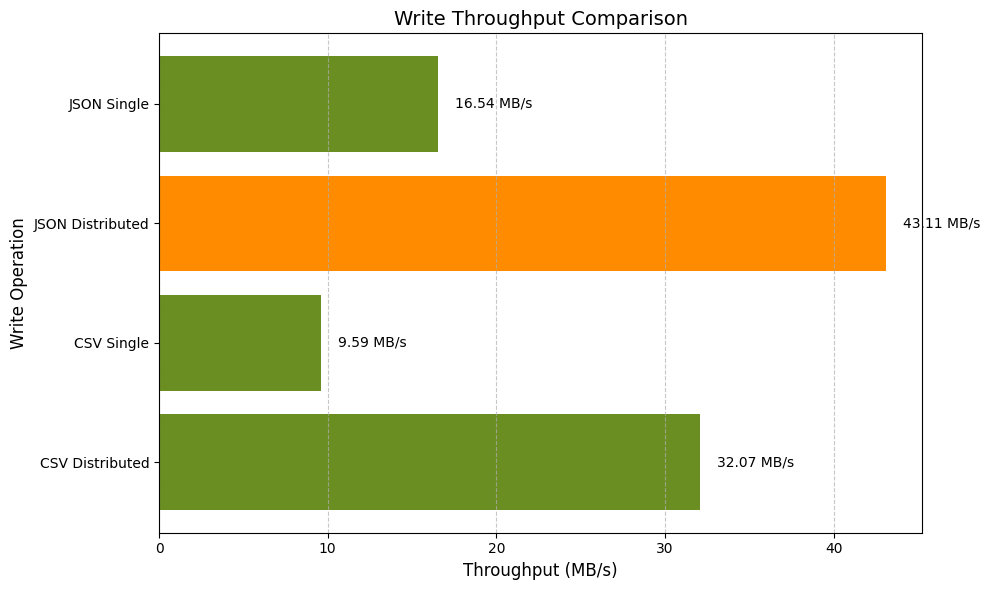

In [37]:
# Extract labels and values
labels = ["CSV Distributed", "CSV Single", "JSON Distributed", "JSON Single"]
throughputs = [write_throughput_csvD, write_throughput_csvS, write_throughput_jsonD, write_throughput_jsonS]

# Determine colors: darkorange for the highest value, olivedrab for the rest
colors = ["darkorange" if value == max(throughputs) else "olivedrab" for value in throughputs]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, throughputs, color=colors)

# Add labels and title
plt.xlabel("Throughput (MB/s)", fontsize=12)
plt.ylabel("Write Operation", fontsize=12)
plt.title("Write Throughput Comparison", fontsize=14)
for index, value in enumerate(throughputs):
    plt.text(value + 1, index, f"{value:.2f} MB/s", va='center', fontsize=10)

# Display the plot
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

